In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("synthetic_mortgage_data.csv")
# Quick overview
print ("shape")
print(df.shape)
print ("\nTypes")
print(df.dtypes)
print ("\nHead")
print(df.head())

# Check missing values
print(df.isnull().sum())

shape
(10000, 33)

Types
borrower_id                     object
gender                          object
age                              int64
education_level                 object
immigration_status              object
marital_status                  object
dependents                       int64
industry_sector                 object
employment_status               object
annual_income                  float64
income_decile                    int64
years_with_current_employer      int64
total_years_employment           int64
income_type                     object
assets                           int64
total_liabilities              float64
net_worth                      float64
liquid_assets                  float64
number_of_open_loans             int64
total_value_of_open_loans      float64
delinquencies_past_12mo          int64
credit_score                     int64
credit_utilization             float64
property_value                   int64
mortgage_amount                  int64


Ordinal encoding categorical data

In [3]:
# Encoding Education Level
education_level_map = {
    'No certificate, diploma or degree': 1,
    'High school diploma or equivalent': 2,
    'Trades or apprenticeship certificate': 3,
    'College or CEGEP certificate or diploma': 4,
    'University transfer program': 5,
    'University certificate or diploma below a bachelor\'s degree': 6,
    'Bachelor\'s degree': 7,
    'University certificate or diploma above a bachelor\'s degree': 8,
    'First professional degree': 9,
    'Master\'s degree': 10,
    'Doctoral degree': 11
}
df['education_level'] = df['education_level'].map(education_level_map)


# Encoding Marital Status
marital_status_map = {
    'Single': 3,
    'Married': 2,
    'Divorced': 1,
    'Widowed': 1
}
df['marital_status'] = df['marital_status'].map(marital_status_map)

# Encoding Industry Sector
industry_sector_map = {
    'Tech': 10,
    'Finance': 9,
    'Healthcare': 8,
    'Education': 7,
    'Manufacturing': 6,
    'Retail': 5,
    'Logistics': 4,
    'Construction': 3,
    'Manual Labor': 2,
    'Other': 1,
}
df['industry_sector'] = df['industry_sector'].map(industry_sector_map)

# Encoding Employment Status: 1 = Student, 2 = Unemployed, 3 = Self-employed, 4 = Employed, 5 = Retired
employment_status_map = {
    'Student': 1,
    'Unemployed': 1,
    'Self-employed': 2,
    'Retired': 2,
    'Employed': 3
}
df['employment_status'] = df['employment_status'].map(employment_status_map)

# Encoding Income Type: 1 = Hourly, 2 = Contract, 3 = Salaried
income_type_map = {
    'Hourly': 1,
    'Contract': 2,
    'Salaried': 3
}
df['income_type'] = df['income_type'].map(income_type_map)

np.random.seed(42)
df['risk_category'] = np.random.choice([0, 1], size=len(df))

# Check if any columns still have NaN values after encoding
print(df.isna().sum())
print 

borrower_id                        0
gender                             0
age                                0
education_level                    0
immigration_status                 0
marital_status                     0
dependents                         0
industry_sector                    0
employment_status                  0
annual_income                      0
income_decile                      0
years_with_current_employer        0
total_years_employment             0
income_type                        0
assets                             0
total_liabilities                  0
net_worth                          0
liquid_assets                      0
number_of_open_loans               0
total_value_of_open_loans          0
delinquencies_past_12mo            0
credit_score                       0
credit_utilization                 0
property_value                     0
mortgage_amount                    0
loan_to_value                      0
monthly_payment                    0
i

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

Risk function

In [4]:
def assign_risk_category(row):
    score = 0

    # Credit Score
    if row['credit_score'] < 580:
        score += 3
    elif row['credit_score'] < 670:
        score += 2
    elif row['credit_score'] < 740:
        score += 1

    # Delinquencies
    if row['delinquencies_past_12mo'] > 2:
        score += 2
    elif row['delinquencies_past_12mo'] > 0:
        score += 1

    # Loan to Value
    if row['loan_to_value'] > 0.9:
        score += 2
    elif row['loan_to_value'] > 0.75:
        score += 1

    # Annual Income
    if row['annual_income'] < 40000:
        score += 2
    elif row['annual_income'] < 70000:
        score += 1

    return 1 if score >= 4 else 0  # 1 = High Risk, 0 = Low Risk

# Apply scoring to your DataFrame
df['risk_category'] = df.apply(assign_risk_category, axis=1)

Extract Feature Importances using Random Forest Classifier


Feature Importances:
credit_score                   0.463736
annual_income                  0.197164
delinquencies_past_12mo        0.098287
assets                         0.075011
net_worth                      0.025694
total_liabilities              0.022136
liquid_assets                  0.014948
total_value_of_open_loans      0.013878
monthly_payment                0.008584
credit_utilization             0.008009
loan_to_value                  0.007951
property_value                 0.007487
mortgage_amount                0.007337
interest_rate                  0.007112
age                            0.006416
total_years_employment         0.005741
mortgage_start_year            0.005652
years_with_current_employer    0.004361
number_of_open_loans           0.004266
industry_sector                0.004065
education_level                0.003358
dependents                     0.002594
term_years                     0.001917
marital_status                 0.001670
income_type       

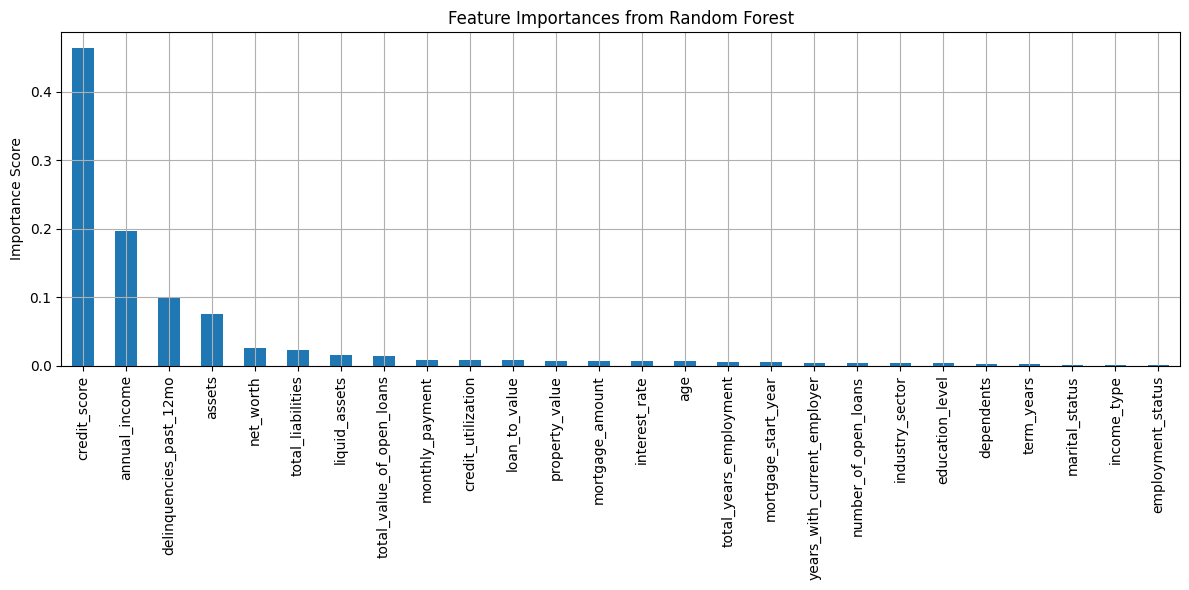

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Exclude columns not to use as input
exclude_cols = ['borrower_id', 'gender', 'immigration_status', 'income_decile', 'risk_category', 'cluster_id', 'after_stress_risk_category']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Prepare features and target
X = df[feature_cols]
y = df['risk_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# Display importances
print("\nFeature Importances:")
print(importances)

# Plot
plt.figure(figsize=(12, 6))
importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Model tuning


Feature Importances:
credit_score                   0.464346
annual_income                  0.200716
delinquencies_past_12mo        0.091679
assets                         0.077110
net_worth                      0.026408
total_liabilities              0.022686
liquid_assets                  0.016835
total_value_of_open_loans      0.013650
monthly_payment                0.009395
credit_utilization             0.008699
property_value                 0.008436
loan_to_value                  0.008394
interest_rate                  0.008161
mortgage_amount                0.007628
age                            0.006562
total_years_employment         0.006166
mortgage_start_year            0.005974
years_with_current_employer    0.004856
number_of_open_loans           0.004297
industry_sector                0.004179
education_level                0.003825
dtype: float64


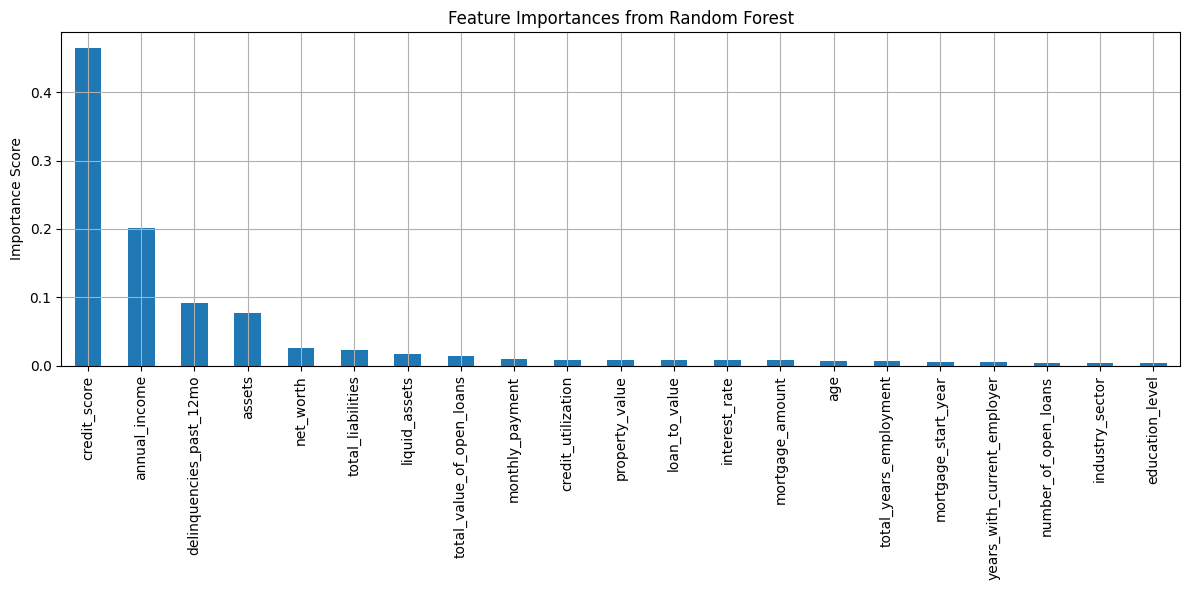

In [6]:
drop_cols = ['marital_status', 'income_type', 'employment_status', 'dependents', 'term_years']

# Combine columns to exclude from the features (you already excluded borrower_id, gender, etc.)
exclude_cols = ['borrower_id', 'gender', 'immigration_status', 'income_decile', 'risk_category', 'cluster_id', 'after_stress_risk_category'] + drop_cols

# Prepare the final feature columns by excluding the unwanted columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Prepare features and target
X = df[feature_cols]
y = df['risk_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# Display importances
print("\nFeature Importances:")
print(importances)

# Plot
plt.figure(figsize=(12, 6))
importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 201, 50),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Features to consider for the best split
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of different combinations to try
                                   cv=5,  # 5-fold cross-validation
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Use the best estimator to make predictions on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optionally, you can check the accuracy
from sklearn.metrics import accuracy_score
print("\nAccuracy: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Maitreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Maitreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Maitreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Maitreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\s

Best Parameters: {'n_estimators': np.int64(150), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       576
           1       1.00      1.00      1.00      1424

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Accuracy:  1.0


Failed fits is because max_features='auto' is no longer valid in recent versions of scikit-learn. It's deprecated and should be removed.

Fine-tuning the model


🟢 Assigned Risk Categories (Before Stress Testing):
risk_category
High Risk    7144
Low Risk     2856
Name: count, dtype: int64

📄 Sample Records with Risk Category Assigned:
  borrower_id  annual_income  credit_score  mortgage_amount  risk_category
0      B00001      101293.41           667           607457              1
1      B00002       58391.17           680           666068              1
2      B00003       83351.90           719           378715              1
3      B00004       66593.74           744           666163              0
4      B00005      154016.07           657           968867              1
5      B00006       57077.56           676           605433              1
6      B00007       76102.72           565           815111              1
7      B00008       13642.68           700           992602              1
8      B00009       84317.81           623           969041              1
9      B00010       84868.59           761           722702              0

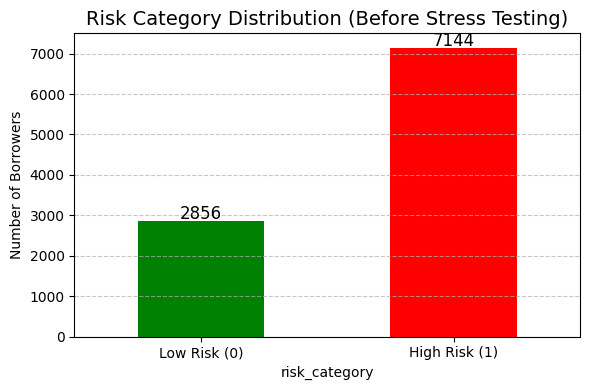

In [8]:
# Define the final feature columns
exclude_cols = ['borrower_id', 'gender', 'immigration_status', 'income_decile', 'risk_category', 'cluster_id', 'after_stress_risk_category']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]

# Final tuned Random Forest model
best_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=None,
    criterion='entropy',
    bootstrap=False,
    random_state=42
)

# Fit the model
best_rf.fit(X, df['risk_category'])

# Predict risk categories
df['risk_category'] = best_rf.predict(X)

# Show value counts
print("\n🟢 Assigned Risk Categories (Before Stress Testing):")
print(df['risk_category'].value_counts().rename({0: 'Low Risk', 1: 'High Risk'}))

# Show few samples with risk category
print("\n📄 Sample Records with Risk Category Assigned:")
print(df[['borrower_id', 'annual_income', 'credit_score', 'mortgage_amount', 'risk_category']].head(10))

# Visualization
plt.figure(figsize=(6, 4))
ax = df['risk_category'].value_counts().sort_index().plot(kind='bar', color=['green', 'red'])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Customize plot
plt.xticks(ticks=[0, 1], labels=['Low Risk (0)', 'High Risk (1)'], rotation=0)
plt.title('Risk Category Distribution (Before Stress Testing)', fontsize=14)
plt.ylabel('Number of Borrowers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Load the original synthetic dataset
df_orig = pd.read_csv('synthetic_mortgage_data.csv')

# Load the DataFrame that has the updated risk_category (from your modeling output)
# This should include at least: borrower_id, risk_category
df_risk = df[['borrower_id', 'risk_category']]

# Merge risk categories into the original data based on borrower_id
df_updated = df_orig.drop(columns=['risk_category'], errors='ignore')  # Remove existing risk_category if present
df_updated = df_updated.merge(df_risk, on='borrower_id', how='left')

# Save the updated dataset back to a new file
df_updated.to_csv('mortgage_data_with_risk_categories.csv', index=False)